# Testing one target

Saved residuals to Hamal_residuals_matrix_noise_100.0_readout_noise_0.0_tint_10min.npy
Saved residuals to Hamal_residuals_matrix_noise_100.0_readout_noise_0.0_tint_20min.npy
Saved residuals to Hamal_residuals_matrix_noise_100.0_readout_noise_0.0_tint_30min.npy


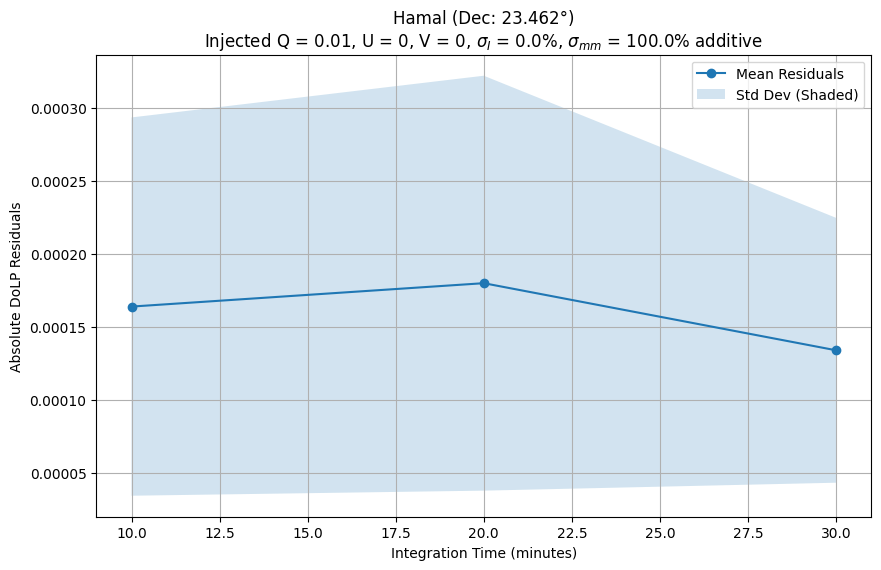

Saved residuals to Mirfak_residuals_matrix_noise_100.0_readout_noise_0.0_tint_10min.npy


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../python/')
import angles
import instrument_mm

# Define observer parameters
observer_latitude = 20.0  # Latitude of Mauna Kea in degrees
observer_longitude = -155.5  # Longitude of Mauna Kea in degrees

# Define target parameters
targets = [
    {"name": "Hamal", "ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
    {"name": "Mirfak", "ra": 51.079, "dec": 49.861},  # Mirfak (Alpha Persei)
    {"name": "Polaris", "ra": 37.954, "dec": 89.264},  # Polaris (Alpha Ursae Minoris)
]

# Observation date and time
observation_date = "2460614.91667"  # JD for 10/31/2024
observation_time = "10:00:00"   # UT time to get peak at midnight HST

# Integration times (in seconds) to test
integration_times = np.arange(10, 31, 10) * 60  # 5, 10, 15, 20 minutes
sub_tint = 1  # Sub-integration time in seconds
num_samples = 100
num_trials = 50  # Number of trials per integration time

# Injected polarization
Q_injected = 0.01  # Injected Stokes Q
U_injected = 0  # Injected Stokes U
V_injected = 0  # Injected Stokes V
noise_percentage = 0  # Intensity noise
matrix_noise = 1  # Example matrix noise

# Loop over each target
for target in targets:
    mean_residuals = []
    std_residuals = []

    # Loop over integration times
    for t_int in integration_times:
        residuals = []

        # Perform multiple trials for each integration time
        for trial in range(num_trials):
            S_in_retrieved = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
                ra=target["ra"],
                dec=target["dec"],
                observer_latitude=observer_latitude,
                observer_longitude=observer_longitude,
                jd_str=observation_date,
                ut_start=observation_time,
                t_int=t_int,
                Q=Q_injected,
                U=U_injected,
                delta_HWP=0.5,
                noise_percentage=noise_percentage,
                include_V=False,
                sub_tint=sub_tint,
                TMT_matrix_noise=matrix_noise,
                NFIRAOS_matrix_noise=matrix_noise,
                MODHIS_matrix_noise=matrix_noise,
                matrix_noise_type="additive",
                sampled_steps=num_samples,
                observable="intensities"
            )

            # Calculate retrieved polarization
            Q_retrieved, U_retrieved = S_in_retrieved[1], S_in_retrieved[2]
            retrieved_polarization = np.sqrt(Q_retrieved**2 + U_retrieved**2)
            injected_polarization = np.sqrt(Q_injected**2 + U_injected**2)

            # Calculate absolute residuals
            residual = np.abs(injected_polarization - retrieved_polarization)
            residuals.append(residual)

        # Compute mean and standard deviation of residuals for this integration time
        mean_residuals.append(np.mean(residuals))
        std_residuals.append(np.std(residuals))

        # Save residuals as a .npy file
        filename = (
            f"{target['name']}_residuals_matrix_noise_{matrix_noise*100:.1f}_"
            f"readout_noise_{noise_percentage*100:.1f}_tint_{t_int//60}min.npy"
        )
        np.save(filename, np.array(residuals))
        print(f"Saved residuals to {filename}")

    # Plot the results for this target
    plt.figure(figsize=(10, 6))
    integration_times_minutes = np.array(integration_times) / 60
    mean_residuals = np.array(mean_residuals)
    std_residuals = np.array(std_residuals)

    plt.plot(integration_times_minutes, mean_residuals, '-o', label=f"Mean Residuals")
    plt.fill_between(integration_times_minutes,
                     mean_residuals - std_residuals,
                     mean_residuals + std_residuals,
                     alpha=0.2, label="Std Dev (Shaded)")
    plt.xlabel("Integration Time (minutes)")
    plt.ylabel("Absolute DoLP Residuals")
    plt.title(
        f"{target['name']} (Dec: {target['dec']}°)\n"
        f"Injected Q = 0.01, U = 0, V = 0, $\sigma_I$ = {noise_percentage*100:.1f}%, $\sigma_{{mm}}$ = {matrix_noise*100:.1f}% additive"
    )
    plt.grid(True)
    plt.legend()
    plt.show()


# Reading Saved Plot

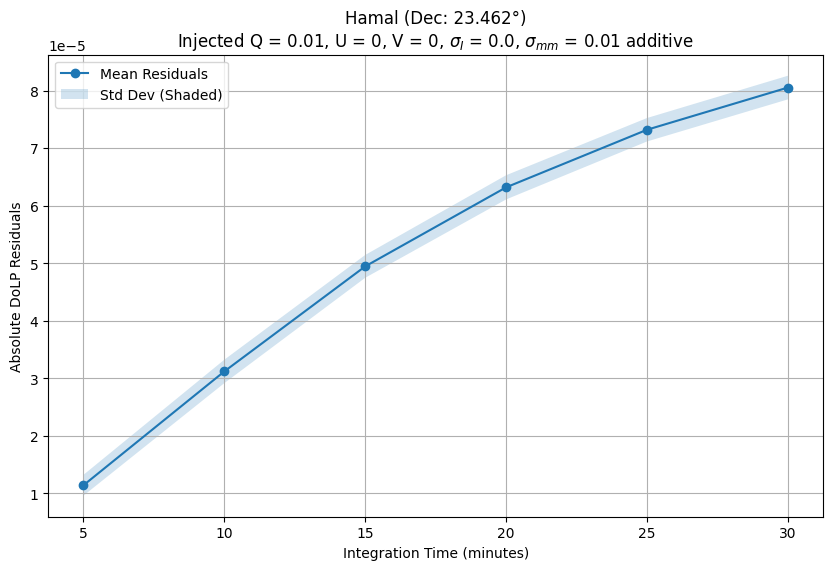

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Configuration parameters
target_name = "Hamal"
dec = 23.462  # Declination of the target
matrix_noise = 0.01  # Example matrix noise in percentage (1%)
noise_percentage = 0  # Readout noise in percentage (0%)
integration_times_minutes = np.arange(5, 31, 5)  # Integration times in minutes
matrix_noise_type = "additive"

# Initialize arrays to store mean and standard deviation of residuals
mean_residuals = []
std_residuals = []

# Loop over integration times
for t_int in integration_times_minutes:
    # Construct the filename for each integration time
    filename = (
        f"{target_name}_residuals_matrix_noise_{matrix_noise*100:.1f}_"
        f"readout_noise_{noise_percentage*100:.1f}_tint_{t_int}min.npy"
    )
    # Load residuals from the .npy file
    residuals = np.load(filename)

    # Compute mean and standard deviation
    mean_residuals.append(np.mean(residuals))
    std_residuals.append(np.std(residuals))

# Convert integration times to an array for plotting
integration_times_minutes = np.array(integration_times_minutes)
mean_residuals = np.array(mean_residuals)
std_residuals = np.array(std_residuals)

# Generate the plot
plt.figure(figsize=(10, 6))
plt.plot(integration_times_minutes, mean_residuals, '-o', label="Mean Residuals")
plt.fill_between(
    integration_times_minutes,
    mean_residuals - std_residuals,
    mean_residuals + std_residuals,
    alpha=0.2,
    label="Std Dev (Shaded)"
)
plt.xlabel("Integration Time (minutes)")
plt.ylabel("Absolute DoLP Residuals")
plt.title(
    f"{target_name} (Dec: {dec}°)\n"
    f"Injected Q = 0.01, U = 0, V = 0, $\sigma_I$ = {noise_percentage*100:.1f}, $\sigma_{{mm}}$ = {matrix_noise} " + matrix_noise_type
)
plt.grid(True)
plt.legend()
plt.show()
